<a href="https://colab.research.google.com/github/TimonKazman/DataAnalyticsProjects/blob/main/KaggleComp_space_ship_multiple_ML_hypertuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing all Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.model_selection import train_test_split


sns.set_style("whitegrid")

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None) 

%matplotlib inline

In [2]:
#Multiple ML to find a promissing ml algorithm

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier

import xgboost as xgb

from sklearn.metrics import auc, plot_confusion_matrix, accuracy_score,roc_auc_score , confusion_matrix, mean_squared_error, classification_report, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV, LeaveOneOut, cross_validate

### Load data

In [123]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Exploratory Data Analysis

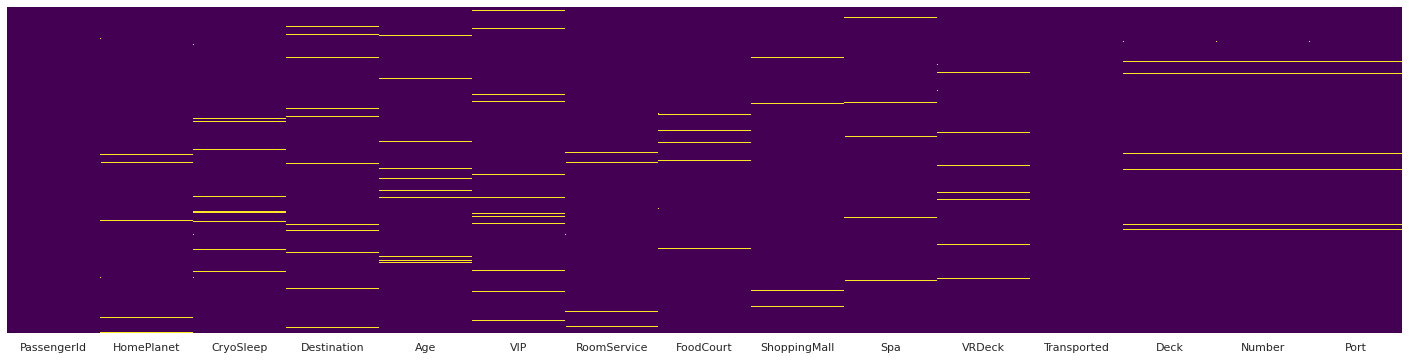

In [158]:
#check for missing values
plt.figure(figsize=(25,6))
sns.heatmap(train.isnull(), yticklabels=False, cbar = False, cmap='viridis')

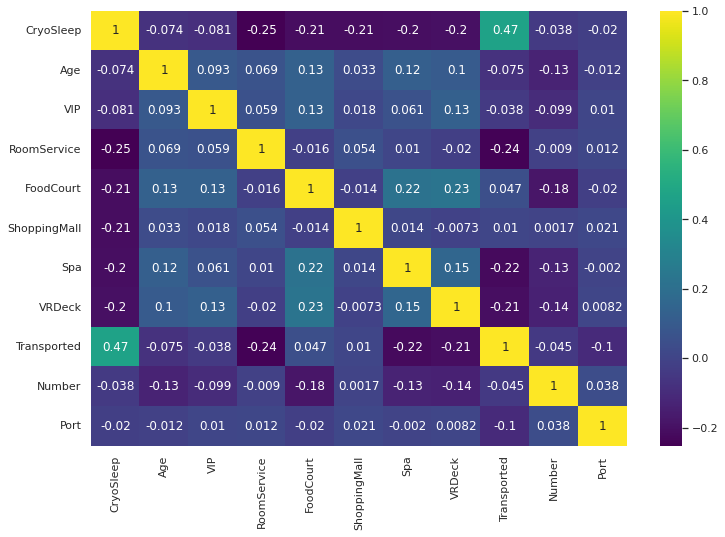

In [157]:
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(),cmap='viridis', annot=True)
#interessing features for transported -> cryosleep, roomservice, spa,vrdeck

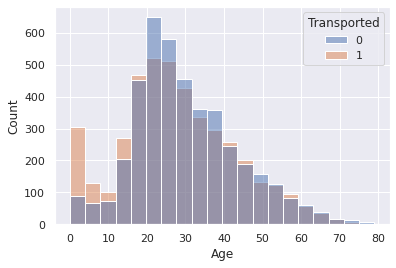

In [156]:
sns.histplot(data = train, x='Age', bins= 20, hue="Transported")

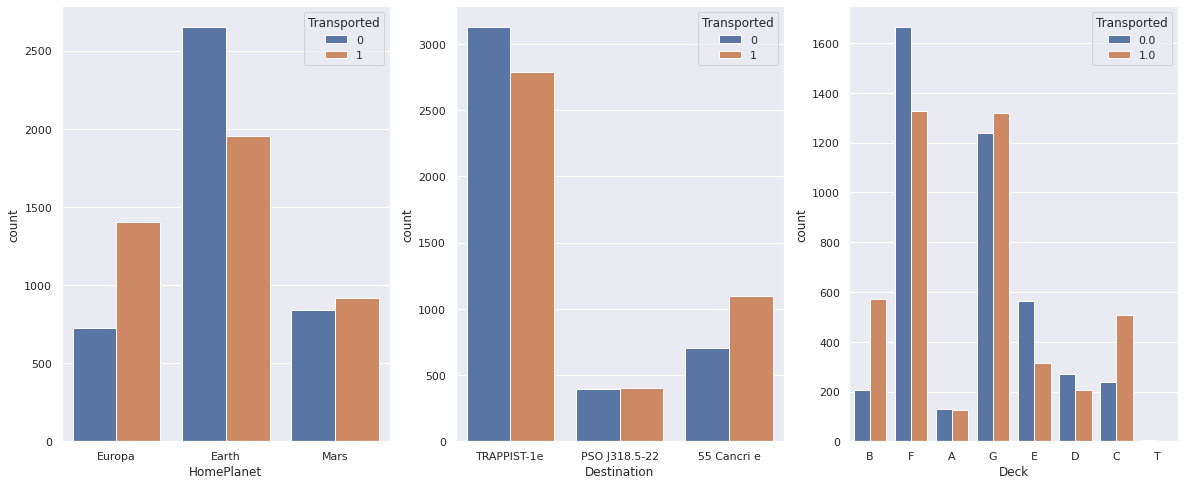

In [155]:
fig, axs = plt.subplots(ncols=3, figsize=(20,8))
sns.countplot(data =train, x="HomePlanet", ax=axs[0], hue="Transported")
sns.countplot(data =train, x="Destination", ax=axs[1], hue="Transported")
sns.countplot(data=train_imputed, x="Deck", ax=axs[2], hue="Transported")

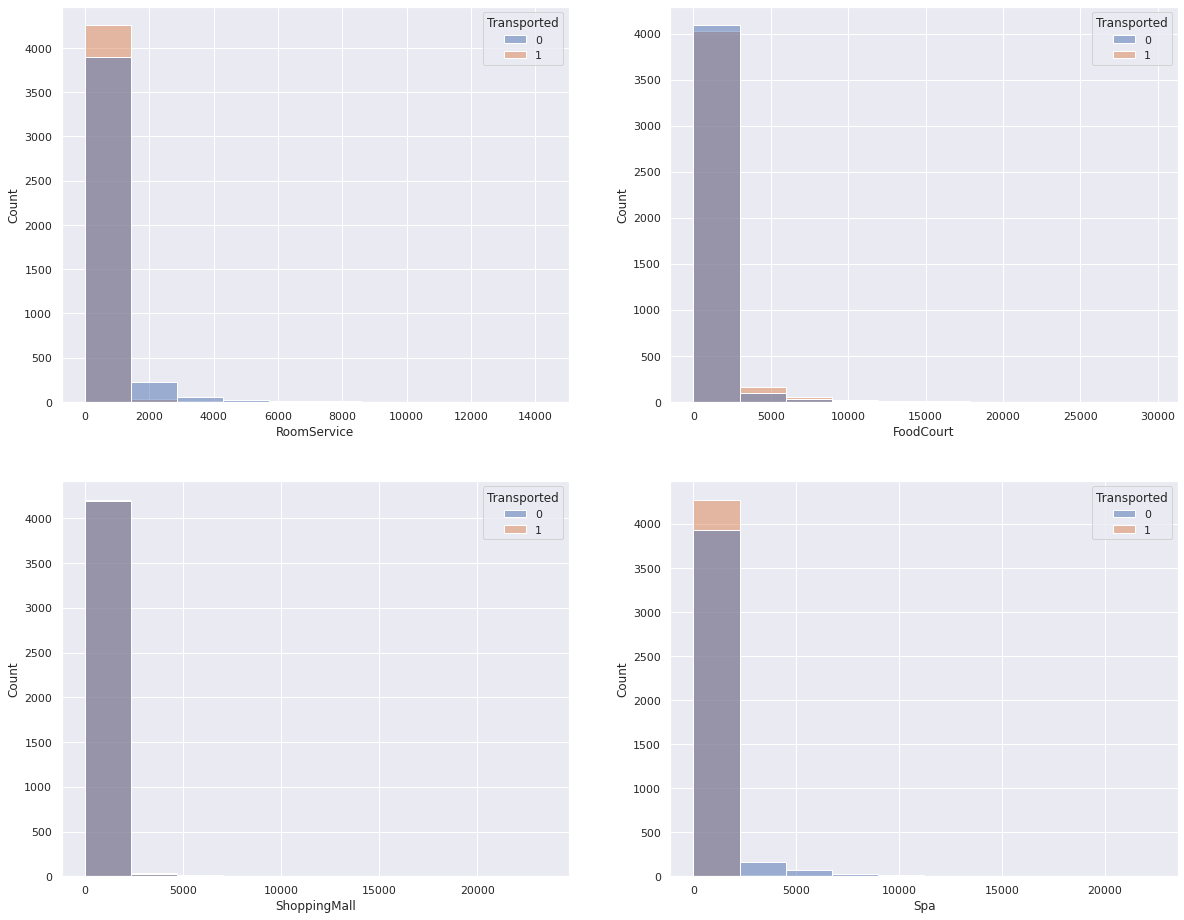

In [154]:
fig, (ax1,ax2) = plt.subplots(ncols = 2, nrows = 2, figsize=(20,16))
sns.histplot(data = train, x="RoomService", bins = 10, ax=ax1[0], hue="Transported")
sns.histplot(data = train, x="FoodCourt", bins = 10, ax=ax1[1], hue="Transported")
sns.histplot(data = train, x="ShoppingMall", bins = 10, ax=ax2[0], hue="Transported")
sns.histplot(data = train, x="Spa", bins = 10, ax=ax2[1], hue="Transported")

### Data Preprocessing

In [134]:
##########################################
#boolean to 1 or 0
boolean = ["CryoSleep", "VIP", "Transported"]

for column in boolean:
    train[column] = train[column].map({True: 1, False: 0})

In [135]:
#########################################
#split one column into 3
train[["Deck", "Number", "Port"]] = train.Cabin.str.split("/",expand=True)
train.drop("Cabin", inplace=True, axis=1)

In [136]:
###############################################
train["Port"] = train["Port"].map({"P":1,"S":0})

In [137]:
##############################################
train.drop("Name", inplace=True, axis=1)

In [138]:
###############################################
train["Number"]=pd.to_numeric(train.Number, errors='coerce')

In [139]:
#############################################
#extract categorical and numerical values
num_vars = train.select_dtypes(include=[np.number])
cat_vars = train.select_dtypes(include=[object])

#handle missing numerical values
num_imputer = KNNImputer(n_neighbors=9)
num_imputed = num_imputer.fit_transform(num_vars)
df_num_imputed = pd.DataFrame(num_imputed, columns=num_vars.columns)

#handle missing categorical values
cat_imputer = SimpleImputer(strategy="most_frequent")
cat_imputed = cat_imputer.fit_transform(cat_vars)
df_cat_imputed = pd.DataFrame(cat_imputed, columns=cat_vars.columns)

In [140]:
############################################
# concat all dataframes
train_imputed = pd.concat([df_cat_imputed, df_num_imputed], axis=1)


In [141]:
################################################
#HomePlanet + Destination + Deck onehotencode
cat_vars = train_imputed[["HomePlanet", "Destination", "Deck"]].values

encoder = OneHotEncoder(handle_unknown='ignore')

encoder.fit(cat_vars)

one_hot = encoder.transform(cat_vars)

train_encoded = pd.DataFrame(one_hot.toarray(), columns=encoder.get_feature_names_out(["HomePlanet", "Destination", "Deck"]))

#concat imputed dataframe and onehotencoded dataframe for complete preprocessed dataframe

train_encoded = pd.concat([train_imputed.drop(["Deck", "HomePlanet", "Destination"], axis=1), train_encoded], axis=1)

In [12]:
train_ml = train_encoded.copy()

In [152]:
train_ml.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Number,Port,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,0001_01,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0002_01,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0003_01,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0003_02,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0004_01,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [14]:
scale_data = train_ml[["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck","Number"]]

In [15]:
# Initiate scaler             >>>>>>>>>>>>>>> need to scale data but not the boolean values <<<<<<<<<<<<<<<<<<<<<
sc = StandardScaler()
# Standardize the training dataset
scale_data = pd.DataFrame(sc.fit_transform(scale_data),index=scale_data.index, columns=scale_data.columns)

scale_data = pd.concat([train_ml.drop(["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck","Number"], axis=1), scale_data], axis=1)

In [153]:
scale_data.head()

,PassengerId,CryoSleep,VIP,Port,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Number
0,0013_01,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.118372,-0.363437,-0.287938,-0.317504,-0.270849,-0.249695,-1.192406
1,0018_01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.687527,-0.363437,-0.281980,-0.317504,2.283071,-0.249695,-1.190444
2,0019_01,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.166205,-0.363437,-0.287938,-0.317504,-0.270849,-0.249695,-1.198294
3,0021_01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.664215,-0.363437,4.115806,-0.317504,-0.107102,0.223425,-1.196331
4,0023_01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.616382,-0.346825,-0.287938,0.826637,-0.270849,-0.249695,-1.188482


###  Data Preprocessing END

REST EDA

In [146]:
#percentage of outliers

for k,v in train_ml.select_dtypes(include=[np.number]).items():
    
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    iqr = q3 - q1
    v_col = v[(v <= q1 - 1.5 * iqr) | (v >= q3 + 1.5 * iqr)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(train_ml.select_dtypes(include=[np.number]))[0]
    print("%s Outliers = %.2f%%" % (k, perc))

CryoSleep Outliers = 0.00%
Age Outliers = 1.56%
VIP Outliers = 100.00%
RoomService Outliers = 21.45%
FoodCourt Outliers = 21.18%
ShoppingMall Outliers = 21.55%
Spa Outliers = 20.69%
VRDeck Outliers = 20.65%
Transported Outliers = 0.00%
Number Outliers = 0.00%
Port Outliers = 0.00%
HomePlanet_Earth Outliers = 0.00%
HomePlanet_Europa Outliers = 100.00%
HomePlanet_Mars Outliers = 100.00%
Destination_55 Cancri e Outliers = 100.00%
Destination_PSO J318.5-22 Outliers = 100.00%
Destination_TRAPPIST-1e Outliers = 0.00%
Deck_A Outliers = 100.00%
Deck_B Outliers = 100.00%
Deck_C Outliers = 100.00%
Deck_D Outliers = 100.00%
Deck_E Outliers = 100.00%
Deck_F Outliers = 0.00%
Deck_G Outliers = 0.00%
Deck_T Outliers = 100.00%


/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


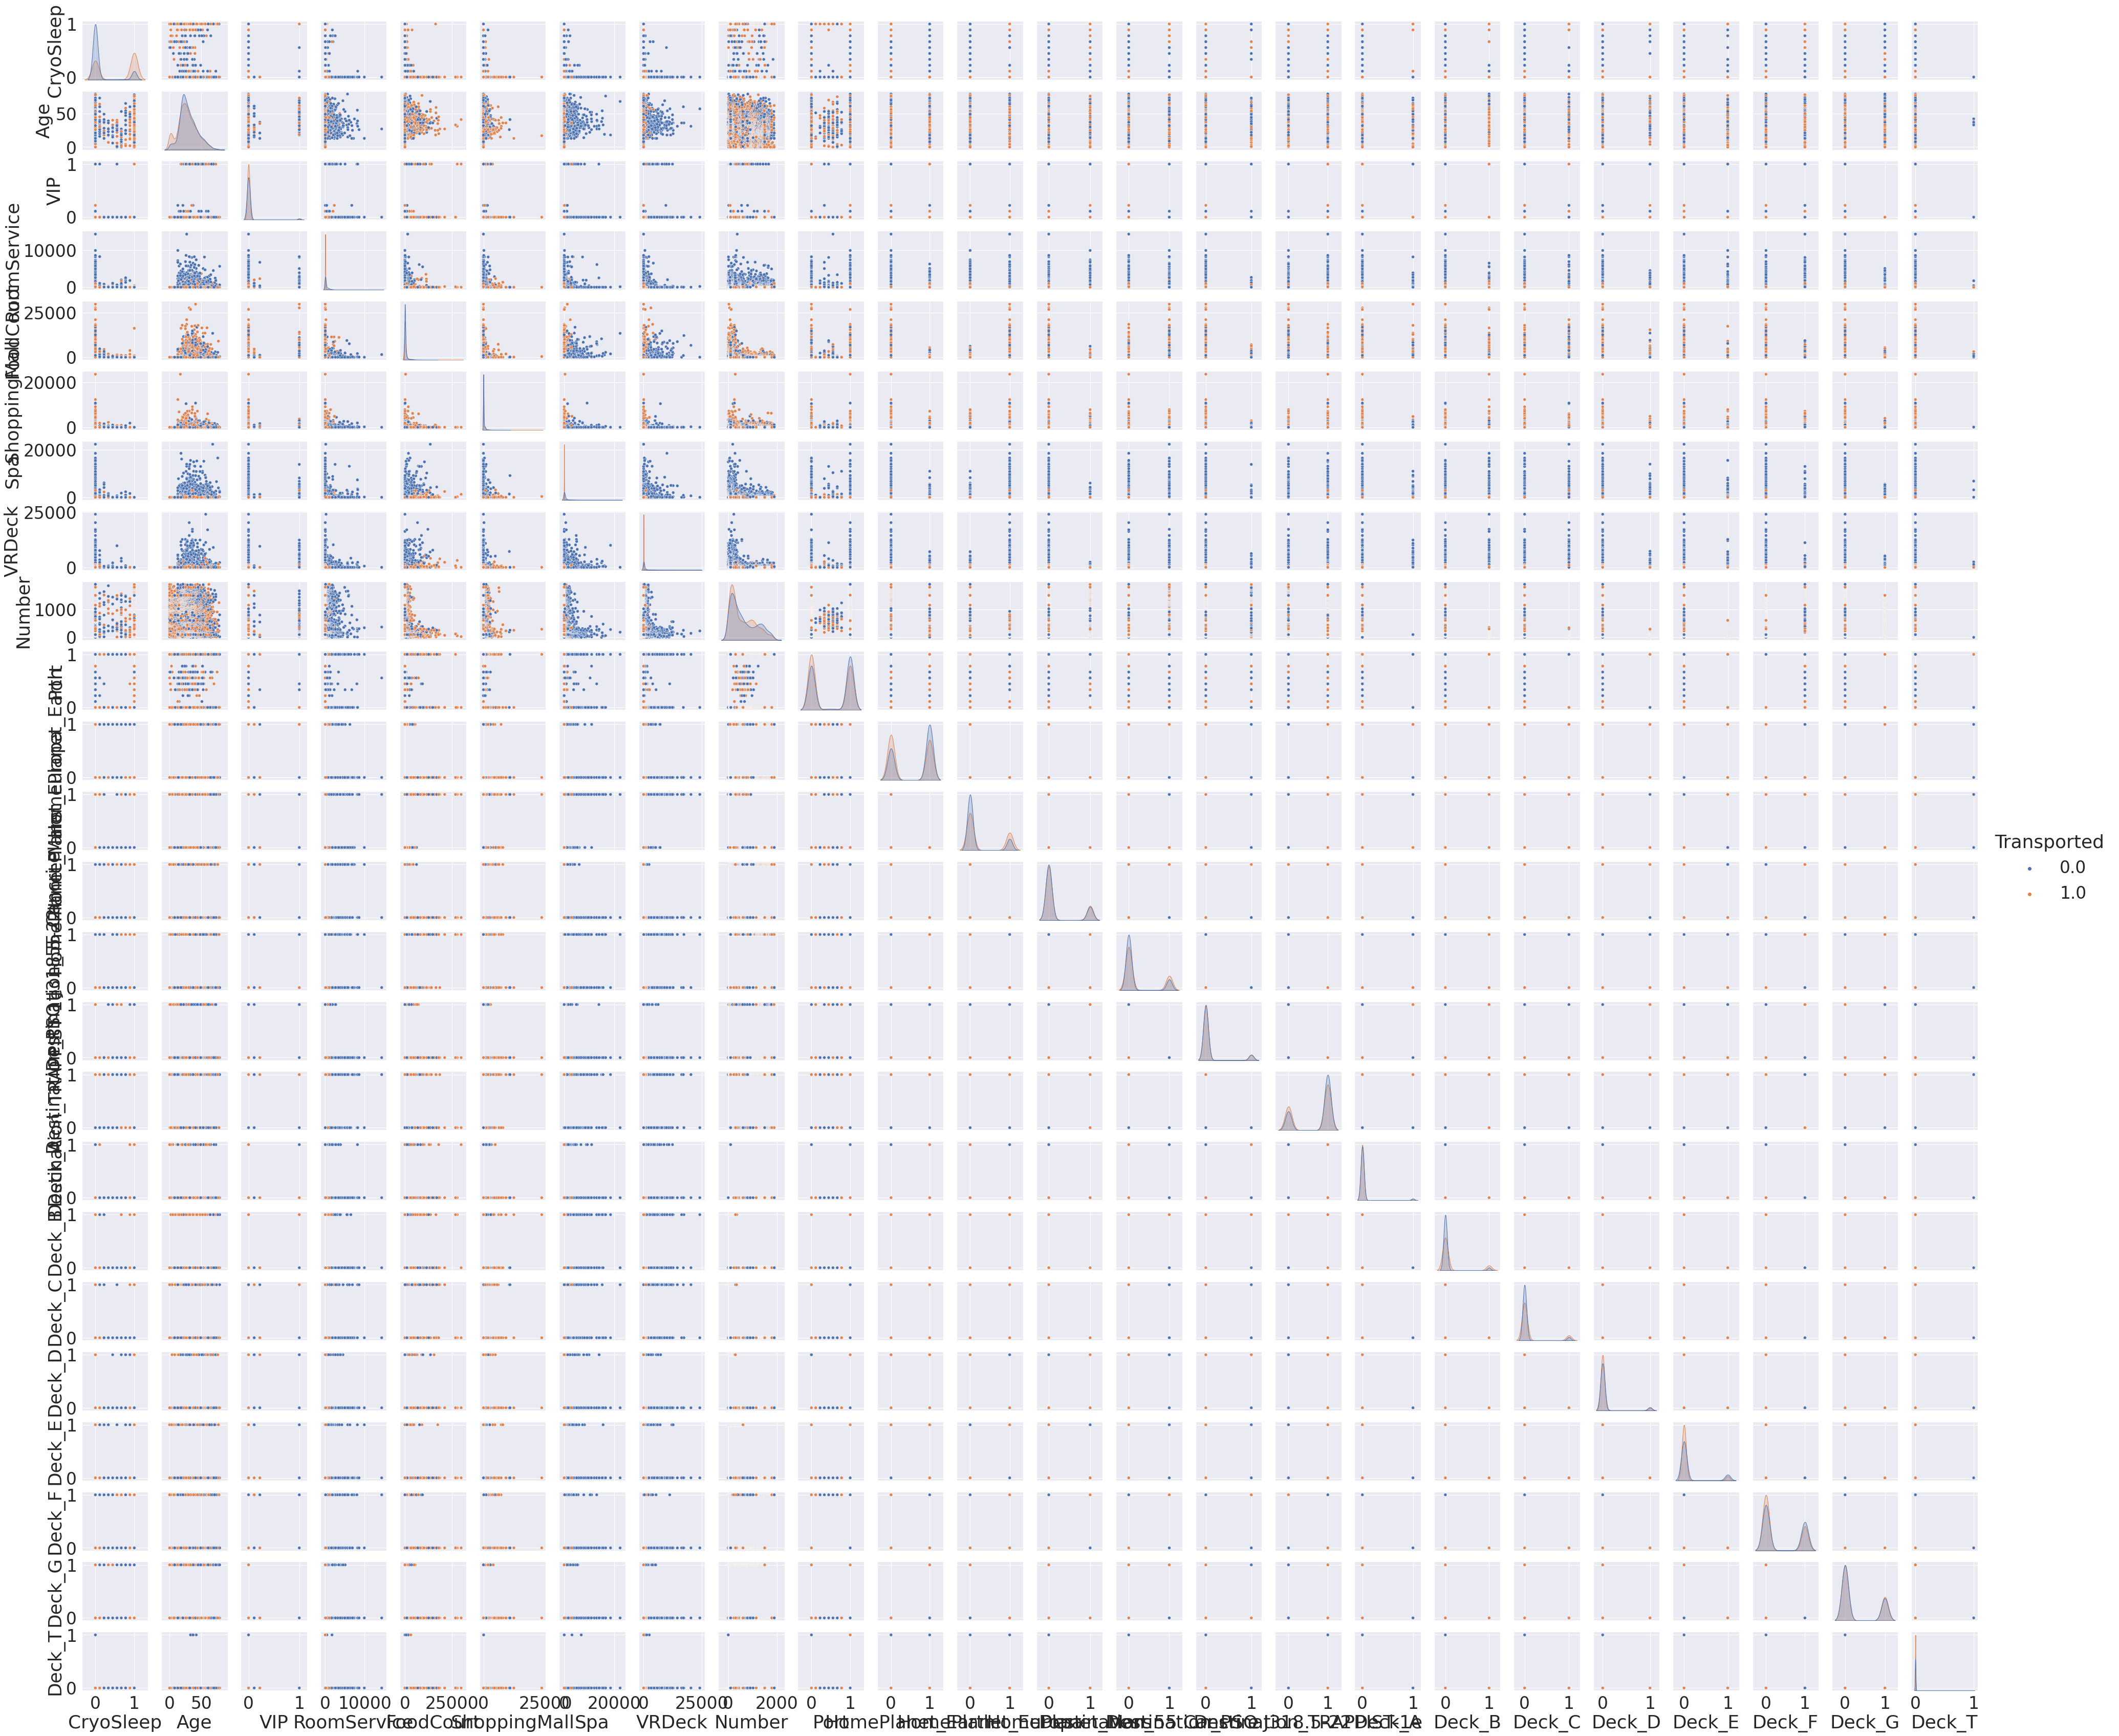

In [147]:
sns.pairplot(train_ml, hue="Transported")

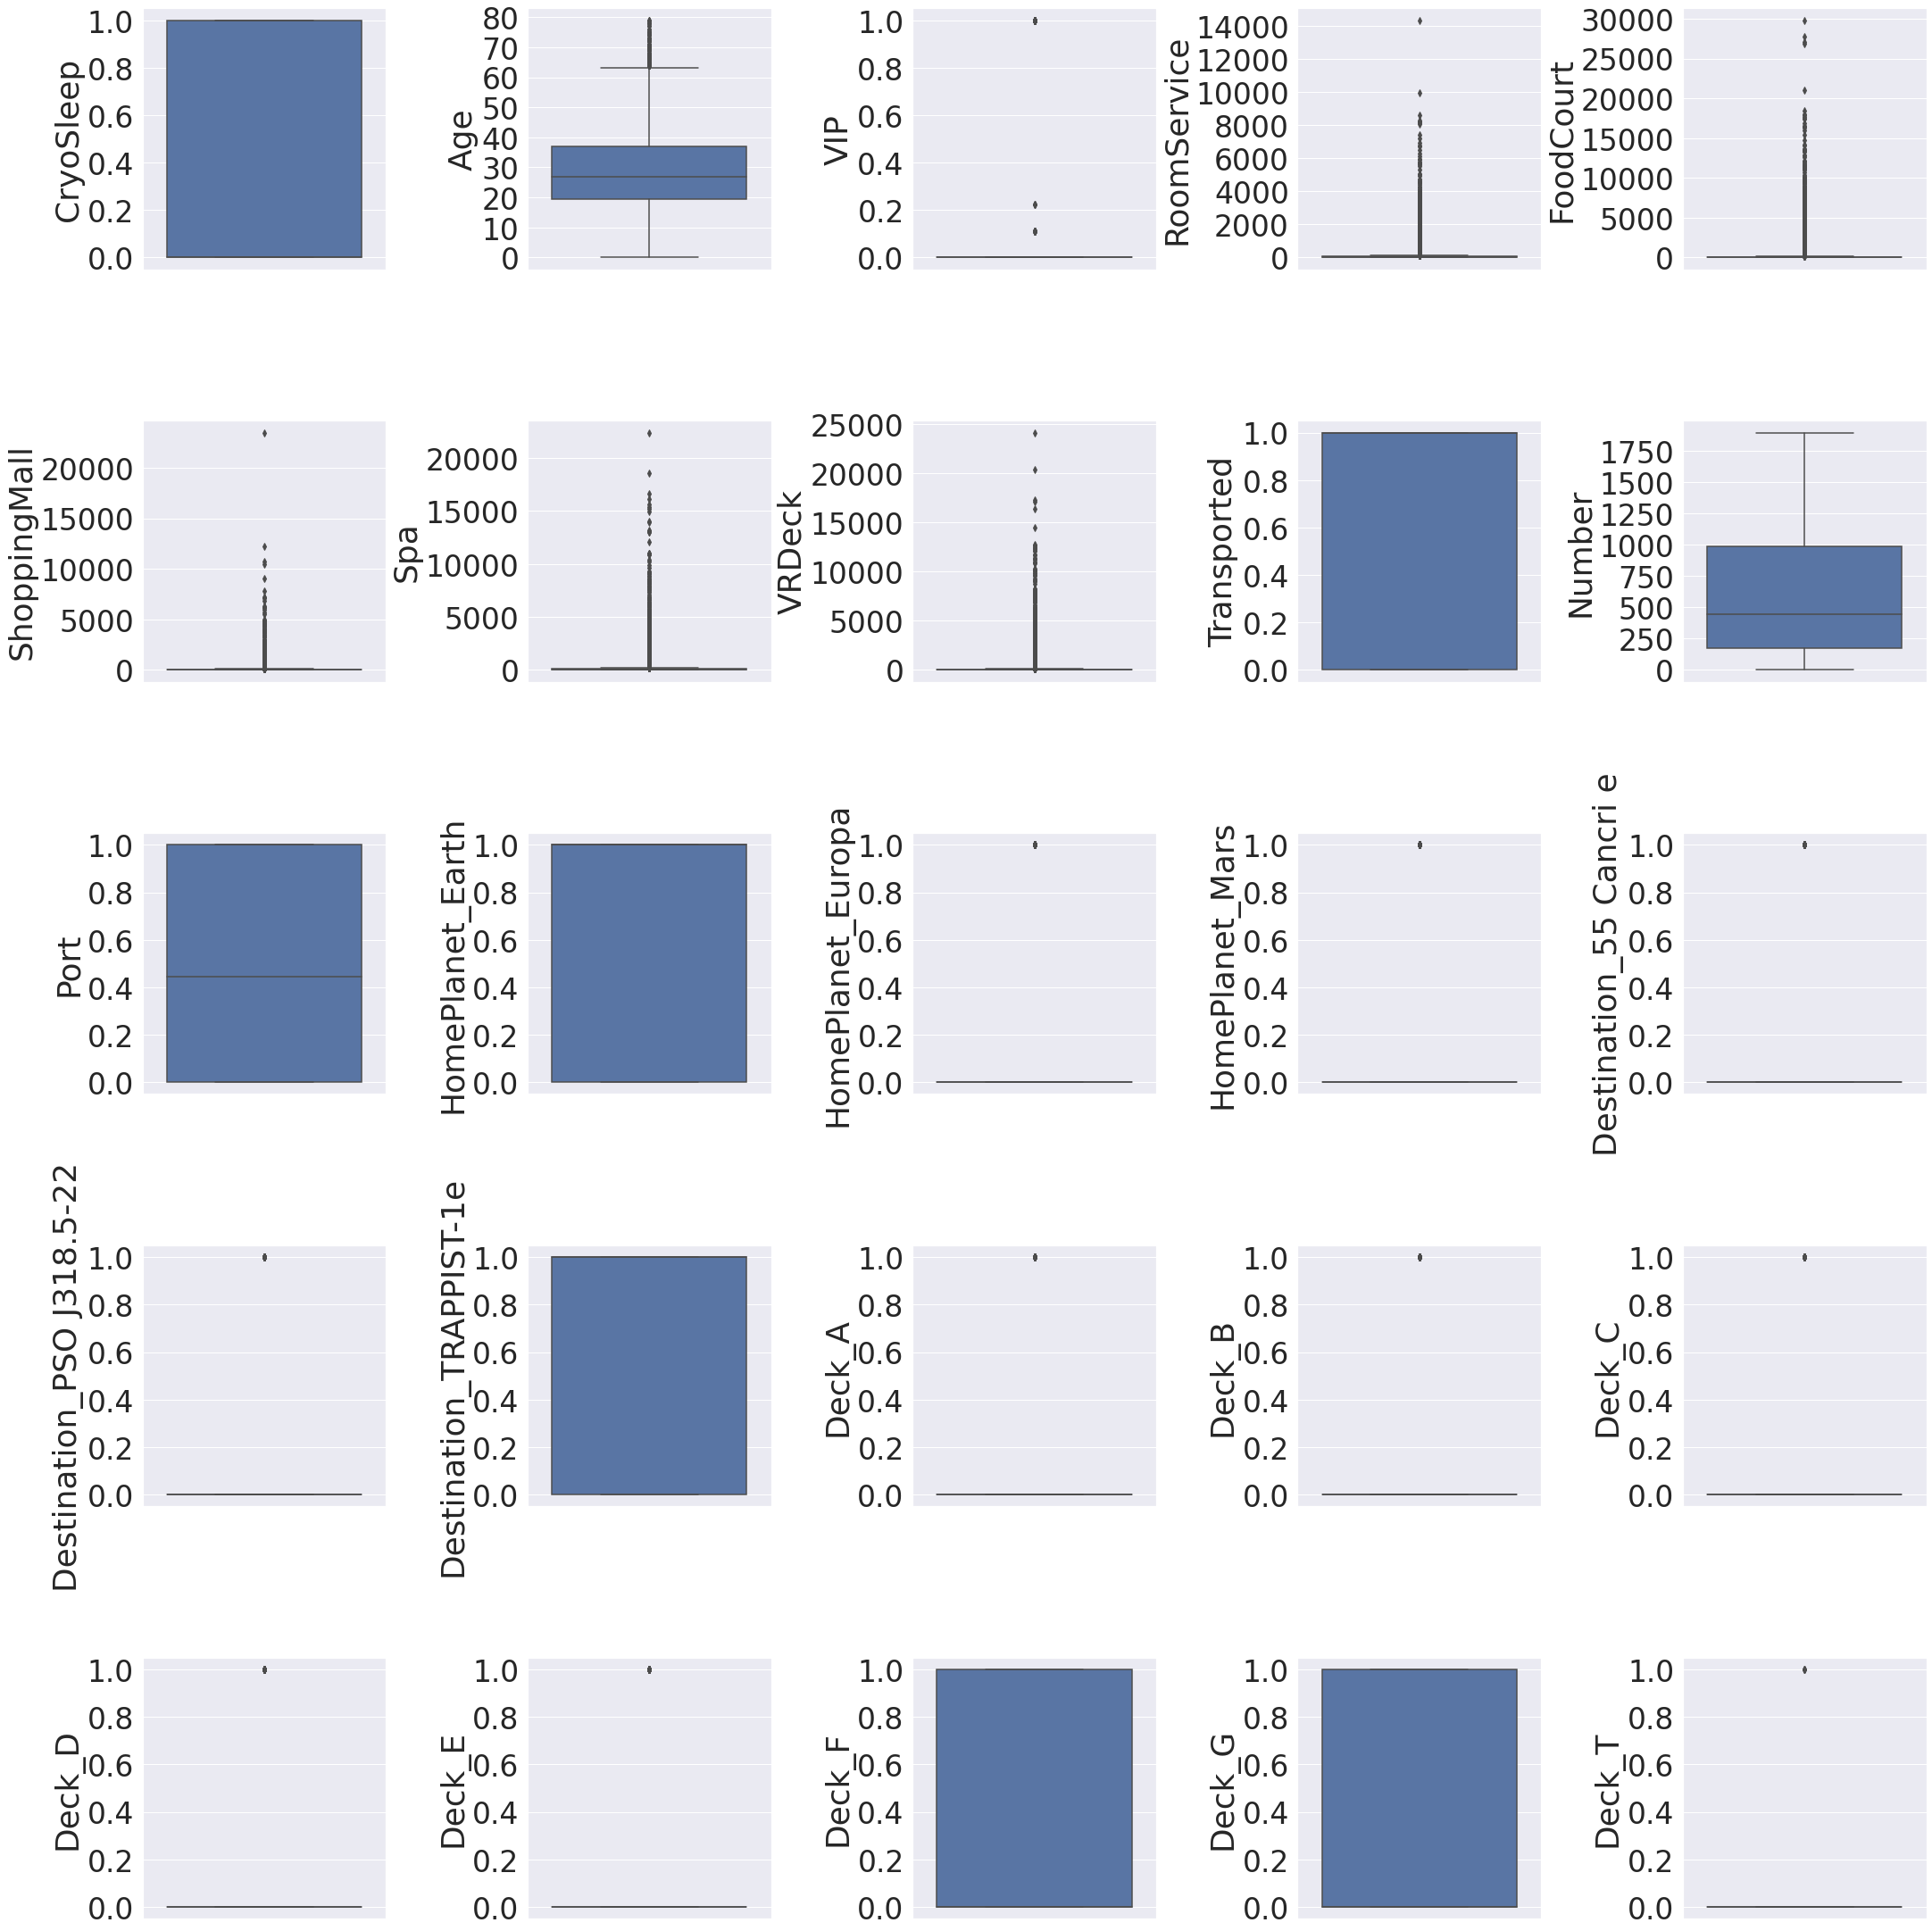

In [151]:
#multiple boxplots to detect all outliers
fig, axs = plt.subplots(ncols=5, nrows=5, figsize=(30,30))
index = 0
sns.set(font_scale=1)
axs = axs.flatten()

for k,v in train_ml.drop("PassengerId", axis=1).items():
    sns.boxplot(y=k, data=train_ml.drop("PassengerId", axis=1), ax=axs[index])
    index +=1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

EDA END

In [17]:
# >>>>>>>>>>>>> IDEAS <<<<<<<<<
#leave one out cv for small dataset
#stratefied kfold cv for imbalanced dataset
#kfold cross val. K~5-10

### Split Data

In [18]:
X = scale_data.drop(["PassengerId","Transported"], axis=1)
y = scale_data["Transported"]
pasId = scale_data["PassengerId"]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

In [20]:
#feature selection
from sklearn.feature_selection import RFE
sv = SVC(kernel="linear", gamma=0.001, C=100)

rfe = RFE(estimator=sv, n_features_to_select=10, step=1)
rfe = rfe.fit(X_train,y_train)

X_train.columns[rfe.support_]

Index(['CryoSleep', 'HomePlanet_Europa', 'Deck_B', 'Deck_C', 'Deck_T',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'],
      dtype='object')

preselecting good ml models

In [149]:
names = ["Nearest_Neighbors", "Linear_SVM", "Polynomial_SVM", "RBF_SVM", "XGBoost",
         "Gradient_Boosting", "Decision_Tree", "Extra_Trees", "Random_Forest", "Neural_Net", "AdaBoost",
         "Naive_Bayes", "QDA", "SGD"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(kernel="poly", degree=3, C=0.025),
    SVC(kernel="rbf", C=1, gamma=2),
    xgb.XGBClassifier(learning_rate =  0.1, max_depth = 2, n_estimators = 50),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
    DecisionTreeClassifier(max_depth=5),
    ExtraTreesClassifier(n_estimators=10, min_samples_split=2),
    RandomForestClassifier(max_depth=5, n_estimators=100),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(n_estimators=100),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    SGDClassifier(loss="hinge", penalty="l2")]

In [150]:
scores = []

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = f1_score(y_test, y_pred, average='micro')
    scores.append(score)

df = pd.DataFrame()
df["name"]=names
df["score"] =scores
df

/usr/local/lib/python3.8/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,name,score
0,Nearest_Neighbors,0.785509
1,Linear_SVM,0.764232
2,Polynomial_SVM,0.771708
3,RBF_SVM,0.767108
4,XGBoost,0.783784
5,Gradient_Boosting,0.794710
6,Decision_Tree,0.780334
7,Extra_Trees,0.789534
8,Random_Forest,0.765382
9,Neural_Net,0.799310


### Use different models to get the best accuracy

In [118]:
#with certain selected features...
X_train_rfe = X_train[X_train.columns[rfe.support_]]
X_test_rfe = X_test[X_train.columns[rfe.support_]]
sv = SVC(kernel="linear", gamma=0.001, C=100)
loo = LeaveOneOut()

clf = cross_validate(sv, 
                     X_train_rfe, 
                     y_train, 
                     scoring='accuracy', 
                     return_train_score=True, 
                     cv=loo, 
                     n_jobs=-1)


print(clf['test_score'])
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

"\nclf = cross_validate(sv, \n                     X_train_rfe, \n                     y_train, \n                     scoring='accuracy', \n                     return_train_score=True, \n                     cv=loo, \n                     n_jobs=-1)\n"

In [ ]:
print(confusion_matrix(y_test, pred))

In [28]:
######################################## use random search ################################
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [10, 1, 0.1, 0.01, 0.001],  
              'degree': [2, 3, 4], 
              'coef0': [0, 1]}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

svc = SVC(kernel="linear")
 
random_search = RandomizedSearchCV(estimator=svc, 
                           param_distributions=param_grid, 
                           n_iter=100,
                           scoring=["accuracy"], 
                           refit='accuracy', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=True)
# Fit grid search
random_result = random_search.fit(X_train, y_train)
# Print grid search summary
random_result

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
                   estimator=SVC(kernel='linear'), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100], 'coef0': [0, 1],
                                        'degree': [2, 3, 4],
                                        'gamma': [10, 1, 0.1, 0.01, 0.001]},
                   refit='accuracy', scoring=['accuracy'], verbose=True)

In [29]:
print(random_result.best_score_)
print(random_result.best_params_)
print(classification_report(y_test, random_result.predict(X_test)))

0.7873166522864539
{'gamma': 0.001, 'degree': 2, 'coef0': 0, 'C': 100}
              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79       863
         1.0       0.80      0.76      0.78       876

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



In [42]:
################################################  use grid_search ######################################
param_grid = {'C':[0.1,1,10],
              'gamma': [1,0.1,0.01]}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
              
'''
param_grid2 = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'degree': [2, 3, 4],
              'shrinking': [True, False],
              'probability': [True, False]}
cv = 10
'''

svc = SVC(kernel="linear", probability=True)

grid_search = GridSearchCV(svc, param_grid, cv=kfold, scoring=['accuracy'], refit='accuracy', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters: ", best_params)

svc = SVC(kernel='linear', **best_params)
svc.fit(X_train,y_train)

test_accuracy = svc.score(X_test, y_test)
print("Test accuracy: ", test_accuracy)

Best hyperparameters:  {'C': 1, 'gamma': 1}
Test accuracy:  0.78205865439908


In [43]:
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79       863
         1.0       0.80      0.76      0.78       876

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



[Text(0, 0.5, 'Not Transported'), Text(0, 1.5, 'Transported')]

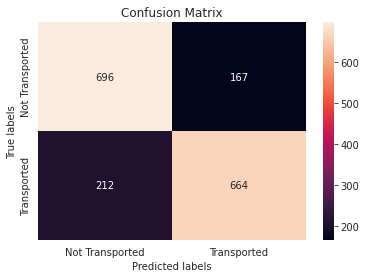

In [45]:
cm = confusion_matrix(y_test, y_pred)

labels = ['Not Transported', 'Transported']

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)


In [46]:
############################################ futher enhance model predictions ##################################
from sklearn.ensemble import BaggingClassifier

base_estimator = SVC(kernel='linear', **best_params)

bagging = BaggingClassifier(base_estimator=base_estimator, n_estimators = 50)
bagging.fit(X_train, y_train)

pred = bagging.predict(X_test)


In [47]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79       863
         1.0       0.80      0.76      0.78       876

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



[Text(0, 0.5, 'Not Transported'), Text(0, 1.5, 'Transported')]

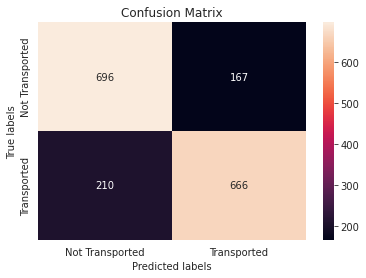

In [48]:
cm = confusion_matrix(y_test, pred)

labels = ['Not Transported', 'Transported']

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [21]:
########################################## use AdaBoost ML-Model #############################
adaboost = AdaBoostClassifier()

base_estimator = DecisionTreeClassifier(max_depth=5, min_samples_split=4)

param_grid = {'n_estimators':[50,100,200], 
              'learning_rate':[0.1,0.5,1.0],
              'base_estimator':[base_estimator]}
#loo = LeaveOneOut()
#kfold = KFold(n_splits=10, shuffle=True, random_state=7)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = 7)

grid = GridSearchCV(estimator=adaboost, 
                    param_grid=param_grid, 
                    scoring='accuracy', 
                    cv =skf, 
                    return_train_score=True,
                    refit=True)

grid_result = grid.fit(X_train,y_train)

print("Best parameters: {}".format(grid_result.best_params_))

print("Best accuracy: {:.2f}".format(grid_result.best_score_*100))

Best parameters: {'base_estimator': DecisionTreeClassifier(max_depth=5, min_samples_split=4), 'learning_rate': 0.1, 'n_estimators': 50}
Best accuracy: 79.62


In [52]:
#kfold
vorhersagen = grid.predict(X_test)
print(classification_report(y_test, vorhersagen))

              precision    recall  f1-score   support

         0.0       0.81      0.80      0.81       863
         1.0       0.81      0.82      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



In [22]:
#skf
vorhersagen = grid.predict(X_test)
print(classification_report(y_test, vorhersagen))

              precision    recall  f1-score   support

         0.0       0.81      0.80      0.81       863
         1.0       0.81      0.82      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



In [23]:
results = pd.DataFrame(grid.cv_results_)[["params", "mean_test_score", "std_test_score"]]
results

,params,mean_test_score,std_test_score
0,{'base_estimator': DecisionTreeClassifier(max_...,0.796232,0.012679
1,{'base_estimator': DecisionTreeClassifier(max_...,0.789762,0.010029
2,{'base_estimator': DecisionTreeClassifier(max_...,0.784153,0.006052
3,{'base_estimator': DecisionTreeClassifier(max_...,0.764021,0.009453
4,{'base_estimator': DecisionTreeClassifier(max_...,0.753236,0.012042
5,{'base_estimator': DecisionTreeClassifier(max_...,0.754529,0.013868
6,{'base_estimator': DecisionTreeClassifier(max_...,0.757981,0.003454
7,{'base_estimator': DecisionTreeClassifier(max_...,0.740867,0.014428
8,{'base_estimator': DecisionTreeClassifier(max_...,0.756111,0.014338


[Text(0, 0.5, 'Not Transported'), Text(0, 1.5, 'Transported')]

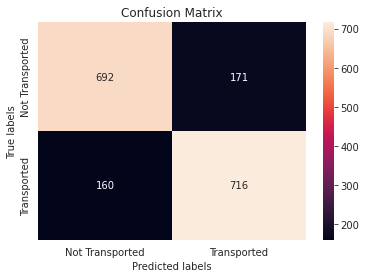

In [26]:
cm = confusion_matrix(y_test, vorhersagen)

labels = ['Not Transported', 'Transported']

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

#### Best Model Performance of ~82% with XGBoost Algorithm

In [48]:
# use XGBoost algorithm

params = {
    'eta': 0.1,
    'max_depth': 5,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 1,
    'alpha': 0,
    'objective': 'binary:logistic',
    'nthread': 4,
    'seed': 42
}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

# Train the XGBoost model using early stopping
early_stopping_rounds = 20
model = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dtest, 'test')],
                  early_stopping_rounds=early_stopping_rounds, verbose_eval=False)

# Predict on the validation set using the best iteration from early stopping
y_pred = model.predict(dtest, ntree_limit=model.best_ntree_limit)
y_pred = np.round(y_pred)

# Evaluate the accuracy of the prediction
accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
print('Accuracy: {:.2f}%'.format(accuracy * 100))

Accuracy: 81.60%


[Text(0, 0.5, 'Not Transported'), Text(0, 1.5, 'Transported')]

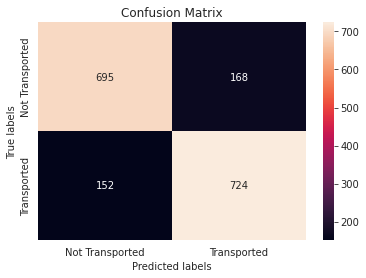

In [35]:
cm = confusion_matrix(y_test, y_pred)

labels = ['Not Transported', 'Transported']

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.81      0.81       863
         1.0       0.81      0.83      0.82       876

    accuracy                           0.82      1739
   macro avg       0.82      0.82      0.82      1739
weighted avg       0.82      0.82      0.82      1739



#### Worse Accuracy with Cross-Validation

In [37]:
# Define the hyperparameters for the XGBoost model
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'lambda': [0, 1, 2],
    'alpha': [0, 1, 2]
}

# Train the XGBoost model using GridSearchCV
model = xgb.XGBClassifier(eta=0.1, objective='binary:logistic', nthread=4, seed=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Predict on the validation set using the best hyperparameters from GridSearchCV
best_params = grid_search.best_params_
best_model = xgb.XGBClassifier(eta=0.1, objective='binary:logistic', 
                               nthread=4, seed=42,max_depth=best_params['max_depth'],
                               min_child_weight=best_params['min_child_weight'],
                               subsample=best_params['subsample'],
                               colsample_bytree=best_params['colsample_bytree'],
                               reg_lambda=best_params['lambda'],
                               alpha=best_params['alpha'])
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Evaluate the accuracy of the prediction
accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
print('Accuracy: {:.2f}%'.format(accuracy * 100))

Accuracy: 80.79%


In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.80      0.80       863
         1.0       0.80      0.82      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



[Text(0, 0.5, 'Not Transported'), Text(0, 1.5, 'Transported')]

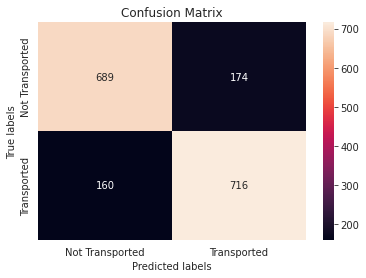

In [39]:
cm = confusion_matrix(y_test, y_pred)

labels = ['Not Transported', 'Transported']

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
############################################################# SUBMITTING AND FITTING TO TEST DATASET FOR KAGGLE COMPETITION ###############################################################

In [60]:
##########################################
#boolean to 1 or 0
boolean = ["CryoSleep", "VIP"]

for column in boolean:
    test[column] = test[column].map({True: 1, False: 0})

In [62]:
#########################################
#split one column into 3
test[["Deck", "Number", "Port"]] = test.Cabin.str.split("/",expand=True)
test.drop("Cabin", inplace=True, axis=1)

In [64]:
###############################################
test["Port"] = test["Port"].map({"P":1,"S":0})

In [66]:
##############################################
test.drop("Name", inplace=True, axis=1)

In [67]:
###############################################
test["Number"]=pd.to_numeric(test.Number, errors='coerce')

In [69]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Number,Port
0,0013_01,Earth,1.0,TRAPPIST-1e,27.0,0.0,0.0,0.0,0.0,0.0,0.0,G,3.0,0.0
1,0018_01,Earth,0.0,TRAPPIST-1e,19.0,0.0,0.0,9.0,0.0,2823.0,0.0,F,4.0,0.0
2,0019_01,Europa,1.0,55 Cancri e,31.0,0.0,0.0,0.0,0.0,0.0,0.0,C,0.0,0.0
3,0021_01,Europa,0.0,TRAPPIST-1e,38.0,0.0,0.0,6652.0,0.0,181.0,585.0,C,1.0,0.0
4,0023_01,Earth,0.0,TRAPPIST-1e,20.0,0.0,10.0,0.0,635.0,0.0,0.0,F,5.0,0.0


In [72]:
test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Deck            100
Number          100
Port            100
dtype: int64

In [74]:
#############################################
#extract categorical and numerical values
num_vars = test.select_dtypes(include=[np.number])
cat_vars = test.select_dtypes(include=[object])

#handle missing numerical values
#num_imputer = KNNImputer(n_neighbors=9)  <<<<<<<<<<<<<<<<<<<<<<
num_imputed = num_imputer.fit_transform(num_vars)
df_num_imputed = pd.DataFrame(num_imputed, columns=num_vars.columns)

#handle missing categorical values
#cat_imputer = SimpleImputer(strategy="most_frequent") <<<<<<<<<<<<<<<<<<<<<<<<
cat_imputed = cat_imputer.fit_transform(cat_vars)
df_cat_imputed = pd.DataFrame(cat_imputed, columns=cat_vars.columns)

In [77]:
############################################
# concat all dataframes
test_imputed = pd.concat([df_cat_imputed, df_num_imputed], axis=1)

In [78]:
################################################
#HomePlanet + Destination + Deck onehotencode
cat_vars = test_imputed[["HomePlanet", "Destination", "Deck"]].values

encoder = OneHotEncoder(handle_unknown='ignore')

encoder.fit(cat_vars)

one_hot = encoder.transform(cat_vars)

test_encoded = pd.DataFrame(one_hot.toarray(), columns=encoder.get_feature_names_out(["HomePlanet", "Destination", "Deck"]))

#concat imputed dataframe and onehotencoded dataframe for complete preprocessed dataframe

test_encoded = pd.concat([test_imputed.drop(["Deck", "HomePlanet", "Destination"], axis=1), test_encoded], axis=1)

In [79]:
test_ml = test_encoded.copy()

In [81]:
scale_data = test_ml[["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck","Number"]]

In [82]:
# Initiate scaler             >>>>>>>>>>>>>>> need to scale data but not the boolean values <<<<<<<<<<<<<<<<<<<<<
sc = StandardScaler()
# Standardize the training dataset
scale_data = pd.DataFrame(sc.fit_transform(scale_data),index=scale_data.index, columns=scale_data.columns)

scale_data = pd.concat([test_ml.drop(["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck","Number"], axis=1), scale_data], axis=1)

In [86]:
X = scale_data.drop(["PassengerId"], axis=1)
#y = scale_data["Transported"]
pasId = scale_data["PassengerId"]

In [94]:
dtest = xgb.DMatrix(data=X)
y_pred = model.predict(dtest, ntree_limit=model.best_ntree_limit)
y_pred = np.round(y_pred)

In [95]:
y_pred

array([1., 0., 1., ..., 1., 1., 1.], dtype=float32)

In [112]:
y_pred_df = pd.DataFrame({'PassengerId':pasId, 'Transported':y_pred})

In [113]:
y_pred_df["Transported"]=y_pred_df.Transported.map({1.0:'True', 0.0:'False'})

In [114]:
y_pred_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [115]:
y_pred_df.to_csv("space_titanic.csv", index=False)